# The Battle of Neighbourhood - Find better place in North York, Toronto


<h2>Data collection</h2>

Import libraries

In [4]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

wikipedia url of data: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Fetch webpage

In [2]:
# Fetch webpage
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
url_response = requests.get(url)
url_response

<Response [200]>

Extract Data from HTML

In [5]:
#Extracting Data
soup=BeautifulSoup(url_response.text,'lxml')
soup.title

postalCodeList = []
boroughList = []
neighborhoodList = []
for row in soup.table.find("tbody").find_all("tr"):
    cells = row.find_all("td")
    for cell in cells:
        i = cell.get_text(separator='*', strip=True).split('*')
        a_data = cell.find_all("a")
        nei = ''
        if len(a_data)>1:
            for a in a_data[1:]:
                if nei == '': 
                    nei += a_data[1].text
                else:
                    nei = nei + ", " + a.text
        if len(a_data)>1:
            postalCodeList.append(i[0])
            boroughList.append(a_data[0].text)
            neighborhoodList.append(nei)

Transfer Data to data frame

In [7]:
# Transfer data to dataframe
toronto_df = pd.DataFrame({"Postal Code": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M9A,Etobicoke,Islington Avenue


Group Data

In [10]:
# Group data
toronto_df = toronto_df.groupby(['Postal Code', 'Borough'], as_index=False).agg(lambda x: ", ".join(x))
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Clean Data

In [15]:
toronto_df = toronto_df[toronto_df.Borough!='Not assigned']
toronto_df = toronto_df[toronto_df.Borough!= 0]
toronto_df.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto_df.shape[0]):
    if toronto_df.iloc[i][2] == 'Not assigned':
        toronto_df.iloc[i][2] = toronto_df.iloc[i][1]
        i = i+1

Check Head

In [16]:
toronto_df.head()


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Check Data shape

In [17]:
toronto_df.shape

(87, 3)

Describe the Data

In [18]:
toronto_df.describe()

,Postal Code,Borough,Neighborhood
count,87,87,87
unique,87,17,83
top,M6N,North York,Downsview
freq,1,23,3


In [21]:
toronto_df = toronto_df.dropna()

In [22]:
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [25]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = toronto_df.groupby(['Postal Code', 'Borough'])
df = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [26]:
df.describe()

,Postal Code,Borough,Neighborhood
count,87,87,87
unique,87,17,83
top,M6N,North York,Downsview
freq,1,23,3


In [27]:
df.shape

(87, 3)

In [28]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


With above steps we performed som additional cleaning and preprocessing

<h3>Collect geolocation information for the dataframe locations</h3>

Install Dependencies

In [29]:
!pip install geocoder

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 9.2 MB/s  eta 0:00:01


Import required libs

In [30]:
import geocoder

Module to fetch location data

In [31]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

Fetch and append location data to data frame

In [34]:
postal_codes = df['Postal Code']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

Check the head of latest data frame

In [37]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [45]:
from geopy.geocoders import Nominatim

address = 'North York,Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Geograpical Co-ordinate of North York,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York,Toronto are 43.7543263, -79.44911696639593.


Install Folium to use map

In [40]:
!pip install folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.7 MB/s  eta 0:00:01


Import neccesary lib

In [41]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize

In [42]:
df.shape

(87, 5)

<h3>Map of North York, Toronto with neighborhoods super imposed on top</h3>

In [47]:
# create map of North York, Toronto using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_ny)  
    
map_ny

In [49]:
latitude

43.7543263

In [50]:
longitude

-79.44911696639593

<h3>Collect data from Foursquare</h3>

Foursquare conf

In [51]:
# Foursquare API
CLIENT_ID = 'xxxx'
CLIENT_SECRET = 'xxxx'
VERSION = '20180604'
LIMIT = 30

Fetch the explore api

In [54]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius,
   LIMIT)
results = requests.get(url).json()

Process data 

In [56]:
from pandas import json_normalize
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

Create a data frame of the processed data

In [58]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Nearby Venues or Locations

In [59]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


Categories of Nearby Venues or Locations

In [61]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


clean columns of Dtata frame

In [62]:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

Check Head

In [63]:
nearby_venues.head()

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


Identify the Top 10 categories

In [64]:
df_nearby=pd.Series(nearby_venues.categories)
df_nearby.value_counts()[:10]

Pizza Place                  2
American Restaurant          1
Sushi Restaurant             1
Fried Chicken Joint          1
Deli / Bodega                1
Restaurant                   1
Coffee Shop                  1
Middle Eastern Restaurant    1
Mediterranean Restaurant     1
Name: categories, dtype: int64

Fetch Near by venues

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Nearby Venues of North York

In [68]:
ny_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village
Birch Cliff, Cliffside
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles, L'Amoreaux
Steeles, L'Amoreaux
Upper Rouge
Hillcrest Village
Henry Farm
Bayview Village
York Mills
Newtonbrook
Willowdale
York Mills
Willowdale
Parkwoods
Don Mills
Don Mills, Flemingdon Park
Bathurst Manor, Wilson Heights, Downsview
Northwood Park, York University
Downsview, CFB Toronto
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Thorncliffe Park
The Danforth
Riverdale
The Beaches
Summerhill
Rathnelly, South Hill, Forest Hill, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden Dist

In [69]:
print('There are {} Uniques Categories.'.format(len(ny_venues['Venue Category'].unique())))
ny_venues.groupby('Neighborhood').count().head()

There are 290 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,22,22,22,22,22,22
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview",14,14,14,14,14,14
Bay Street,100,100,100,100,100,100
Bayview Village,6,6,6,6,6,6


One Hot encoding of Features

In [70]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()

In [71]:
ny_onehot.head()

,Zoo Exhibit,Accessories Store,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
num_top_venues = 5
for hood in ny_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                       venue  freq
0              Shopping Mall  0.09
1            Bubble Tea Shop  0.05
2  Latin American Restaurant  0.05
3                       Café  0.05
4           Department Store  0.05


---- Alderwood, Long Branch ----
            venue  freq
0        Pharmacy  0.14
1             Pub  0.14
2  Sandwich Place  0.14
3     Pizza Place  0.14
4             Gym  0.14


---- Bathurst Manor, Wilson Heights, Downsview ----
               venue  freq
0               Park  0.14
1        Coffee Shop  0.14
2       Intersection  0.07
3  Mobile Phone Shop  0.07
4     Sandwich Place  0.07


---- Bay Street ----
                           venue  freq
0                    Coffee Shop  0.12
1                 Clothing Store  0.08
2                    Art Gallery  0.03
3                           Café  0.03
4  Vegetarian / Vegan Restaurant  0.03


---- Bayview Village ----
              venue  freq
0             Trail  0.33
1  Asian Restaurant  0.17
2       Flow

           venue  freq
0           Park   0.4
1    Candy Store   0.2
2  Grocery Store   0.2
3     Playground   0.2
4    Music Venue   0.0


---- Rouge Hill, Port Union, Highland Creek ----
               venue  freq
0                Bar  0.67
1  Fish & Chips Shop  0.33
2        Zoo Exhibit  0.00
3        Music Venue  0.00
4       Optical Shop  0.00


---- Runnymede, The Junction ----
                    venue  freq
0                 Brewery  0.43
1                    Park  0.29
2  Furniture / Home Store  0.14
3      Athletics & Sports  0.14
4             Music Venue  0.00


---- Scarborough Village ----
                  venue  freq
0         Big Box Store  0.25
1        Sandwich Place  0.25
2     Indian Restaurant  0.25
3  Fast Food Restaurant  0.25
4           Music Venue  0.00


---- South Steeles, Silverstone, Jamestown, Mount Olive, Beaumond Heights, Thistletown ----
                  venue  freq
0         Grocery Store  0.14
1           Coffee Shop  0.14
2  Caribbean Restaurant  

Module to get most common venues

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most Common Venues near neighbourhood

In [91]:
# Import
import numpy as np


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pharmacy,Print Shop,Bubble Tea Shop,Breakfast Spot,Café,Sandwich Place,Latin American Restaurant,Supermarket,Sushi Restaurant
1,"Alderwood, Long Branch",Gym,Pizza Place,Pub,Sandwich Place,Coffee Shop,Pharmacy,Gas Station,Elementary School,Doner Restaurant,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview",Coffee Shop,Park,Pizza Place,Fried Chicken Joint,Sandwich Place,Middle Eastern Restaurant,Mediterranean Restaurant,Mobile Phone Shop,Deli / Bodega,Restaurant
3,Bay Street,Coffee Shop,Clothing Store,Café,Vegetarian / Vegan Restaurant,Art Gallery,Japanese Restaurant,Restaurant,Sushi Restaurant,Plaza,Italian Restaurant
4,Bayview Village,Trail,Flower Shop,Park,Gas Station,Asian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room


<h2>K-Means Clustering</h2>

K-Means to cluster neighborhood into 3 clusters

In [92]:
# Import required lib
from sklearn.cluster import KMeans

Fit to model

In [93]:
ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(ny_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32)

In [106]:
ny_df = df.loc[df['Borough'] == "North York"]

In [107]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.80225,-79.35558,0,Park,Bakery,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
18,M2J,North York,Henry Farm,43.78097,-79.34781,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Japanese Restaurant,Juice Bar,Restaurant,Bank,Shoe Store,Beer Store
19,M2K,North York,Bayview Village,43.78112,-79.38060,1,Trail,Flower Shop,Park,Gas Station,Asian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
20,M2L,North York,York Mills,43.75698,-79.38060,1,Restaurant,Optical Shop,Park,Coffee Shop,Thai Restaurant,Indian Restaurant,Sandwich Place,French Restaurant,Food Court,Japanese Restaurant
21,M2M,North York,Newtonbrook,43.79182,-79.41372,1,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Pizza Place,Fried Chicken Joint,Bank,Beer Store,Sushi Restaurant,Supermarket


<h3> Map of the Cluster</h3>

Set clusters value

In [108]:
kclusters = 10

In [109]:
ny_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.80225,-79.35558,0,Park,Bakery,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
18,M2J,North York,Henry Farm,43.78097,-79.34781,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Japanese Restaurant,Juice Bar,Restaurant,Bank,Shoe Store,Beer Store
19,M2K,North York,Bayview Village,43.78112,-79.38060,1,Trail,Flower Shop,Park,Gas Station,Asian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
20,M2L,North York,York Mills,43.75698,-79.38060,1,Restaurant,Optical Shop,Park,Coffee Shop,Thai Restaurant,Indian Restaurant,Sandwich Place,French Restaurant,Food Court,Japanese Restaurant
21,M2M,North York,Newtonbrook,43.79182,-79.41372,1,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Pizza Place,Fried Chicken Joint,Bank,Beer Store,Sushi Restaurant,Supermarket


Build Map with cluster data

In [110]:
# map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(ny_merged['Latitude'], 
                                   ny_merged['Longitude'], 
                                   ny_merged['Neighborhood'], 
                                   ny_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [111]:
df1=ny_merged.loc[ny_merged['Cluster Labels'] == 0,ny_merged.columns[[2] + list(range(5, ny_merged.shape[1]))]]
df2=ny_merged.loc[ny_merged['Cluster Labels'] == 1,ny_merged.columns[[2] + list(range(5, ny_merged.shape[1]))]]
df3=ny_merged.loc[ny_merged['Cluster Labels'] == 2,ny_merged.columns[[2] + list(range(5, ny_merged.shape[1]))]]

Average price data

In [117]:
ny_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               589900.0,295000.0]})

In [118]:
ny_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

Visualisation of House price

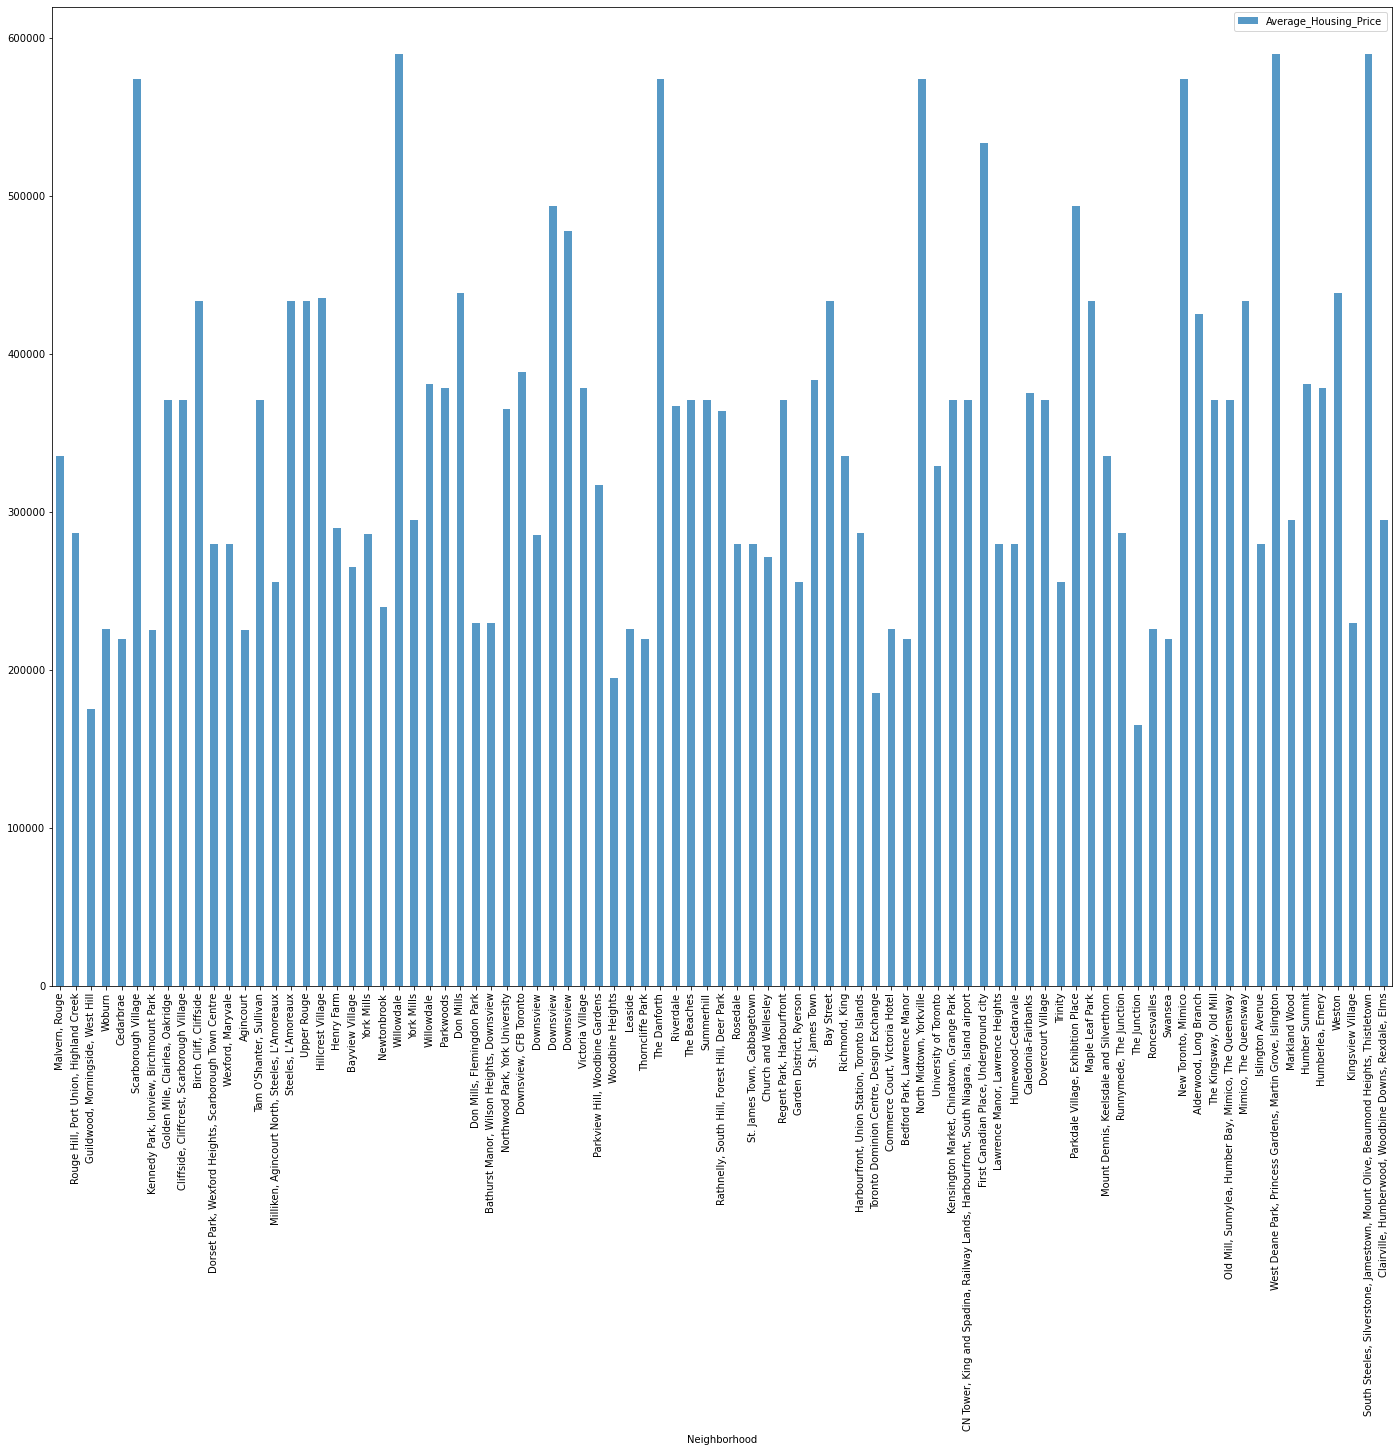

In [119]:
ny_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [120]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [123]:
new_ny=ny_merged.set_index("Neighborhood",drop=True)

# Data source: https://www.greatschools.org
ny_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9
                                                           ]})

In [124]:
ny_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

Visualisation of School rating

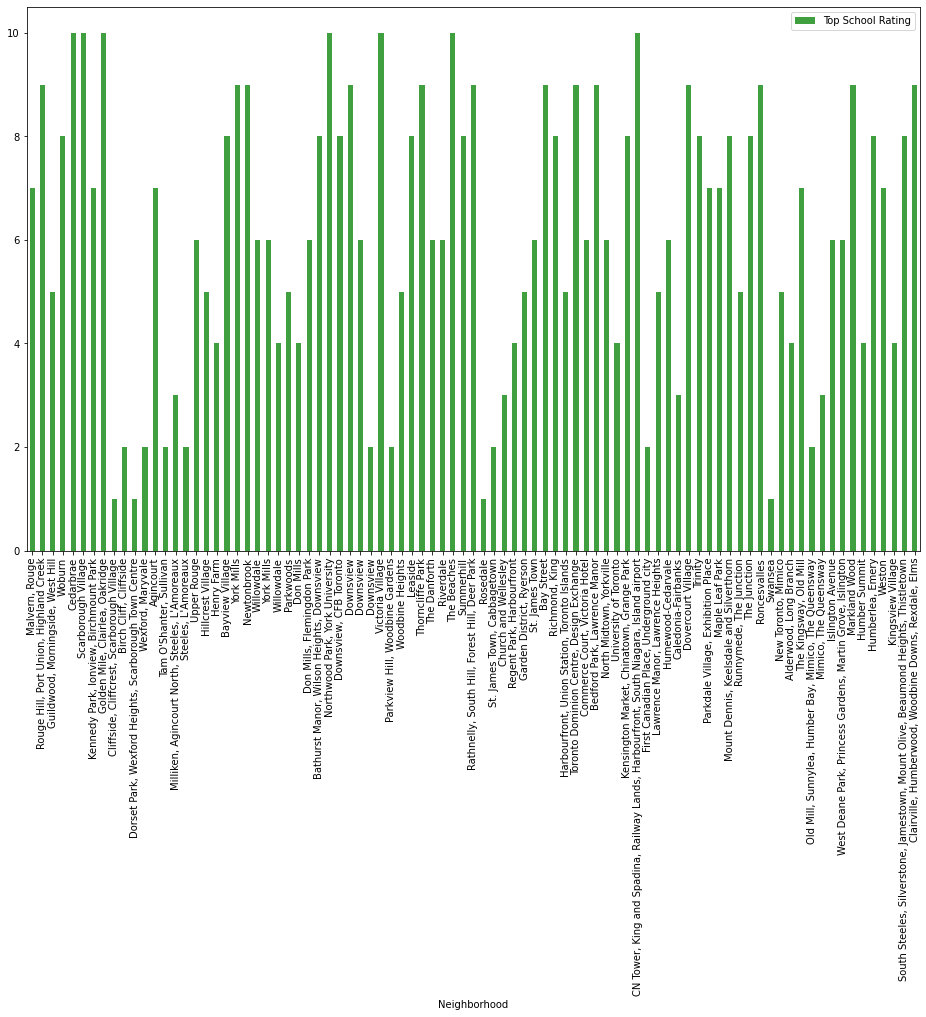

In [125]:
ny_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75)